In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Path to the metadata CSV file
metadata_path = r'C:\Users\viswa\Desktop\Project-X\HAM10000_metadata.csv'
images_path = r'C:\Users\viswa\Desktop\Project-X\HAM10000_images'

# Load the metadata
df = pd.read_csv(metadata_path)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])

# Create directories for train and test data
train_dir = r'HAM10000_sampled\train'
test_dir = r'HAM10000_sampled\test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files to their respective directories
def copy_files(df, source, destination):
    for _, row in df.iterrows():
        filename = row['image_id'] + '.jpg'
        class_label = row['dx']
        class_dir = os.path.join(destination, class_label)
        os.makedirs(class_dir, exist_ok=True)
        src_path = os.path.join(source, filename)
        dst_path = os.path.join(class_dir, filename)
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)

# Copy train and test files
copy_files(train_df, images_path, train_dir)
copy_files(test_df, images_path, test_dir)

# Verify the directory structure
for directory in [train_dir, test_dir]:
    print(f"\nContents of {os.path.basename(directory)}:")
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            print(f"Category: {category}, Number of images: {len(os.listdir(category_path))}")


Contents of train:
Category: akiec, Number of images: 307
Category: bcc, Number of images: 495
Category: bkl, Number of images: 1055
Category: df, Number of images: 112
Category: mel, Number of images: 1064
Category: nv, Number of images: 6409
Category: vasc, Number of images: 136

Contents of test:
Category: akiec, Number of images: 114
Category: bcc, Number of images: 177
Category: bkl, Number of images: 404
Category: df, Number of images: 48
Category: mel, Number of images: 400
Category: nv, Number of images: 2383
Category: vasc, Number of images: 43


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of training data will be used for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)
print("Class indices:", train_generator.class_indices)

Found 7665 images belonging to 7 classes.
Found 1913 images belonging to 7 classes.
Found 3569 images belonging to 7 classes.
Number of training samples: 7665
Number of validation samples: 1913
Number of test samples: 3569
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

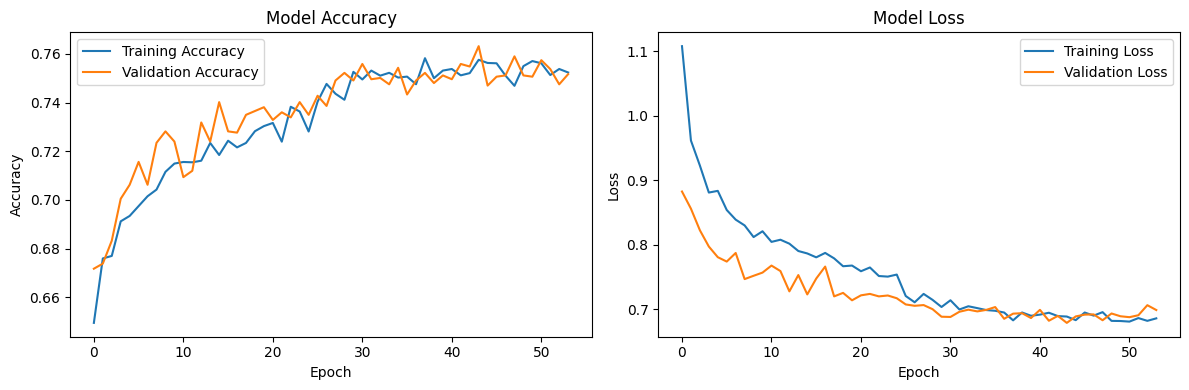

c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Create the model using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save('improved_dermatological_disease_detection_model.h5')

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('improved_dermatological_disease_detection_model.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Path to the image you want to predict
img_path = r'C:\Users\viswa\Downloads\download.jpeg'

# Load and preprocess the image
img = load_and_preprocess_image(img_path)

# Make the prediction
predictions = model.predict(img)

# Determine the predicted class
predicted_class_index = np.argmax(predictions)
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
predicted_class = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {predictions[0][predicted_class_index]:.2f}")

1/1 [==============================] - 2s 2s/step
Predicted class: nv
Confidence: 0.58


112/112 [==============================] - 58s 515ms/step


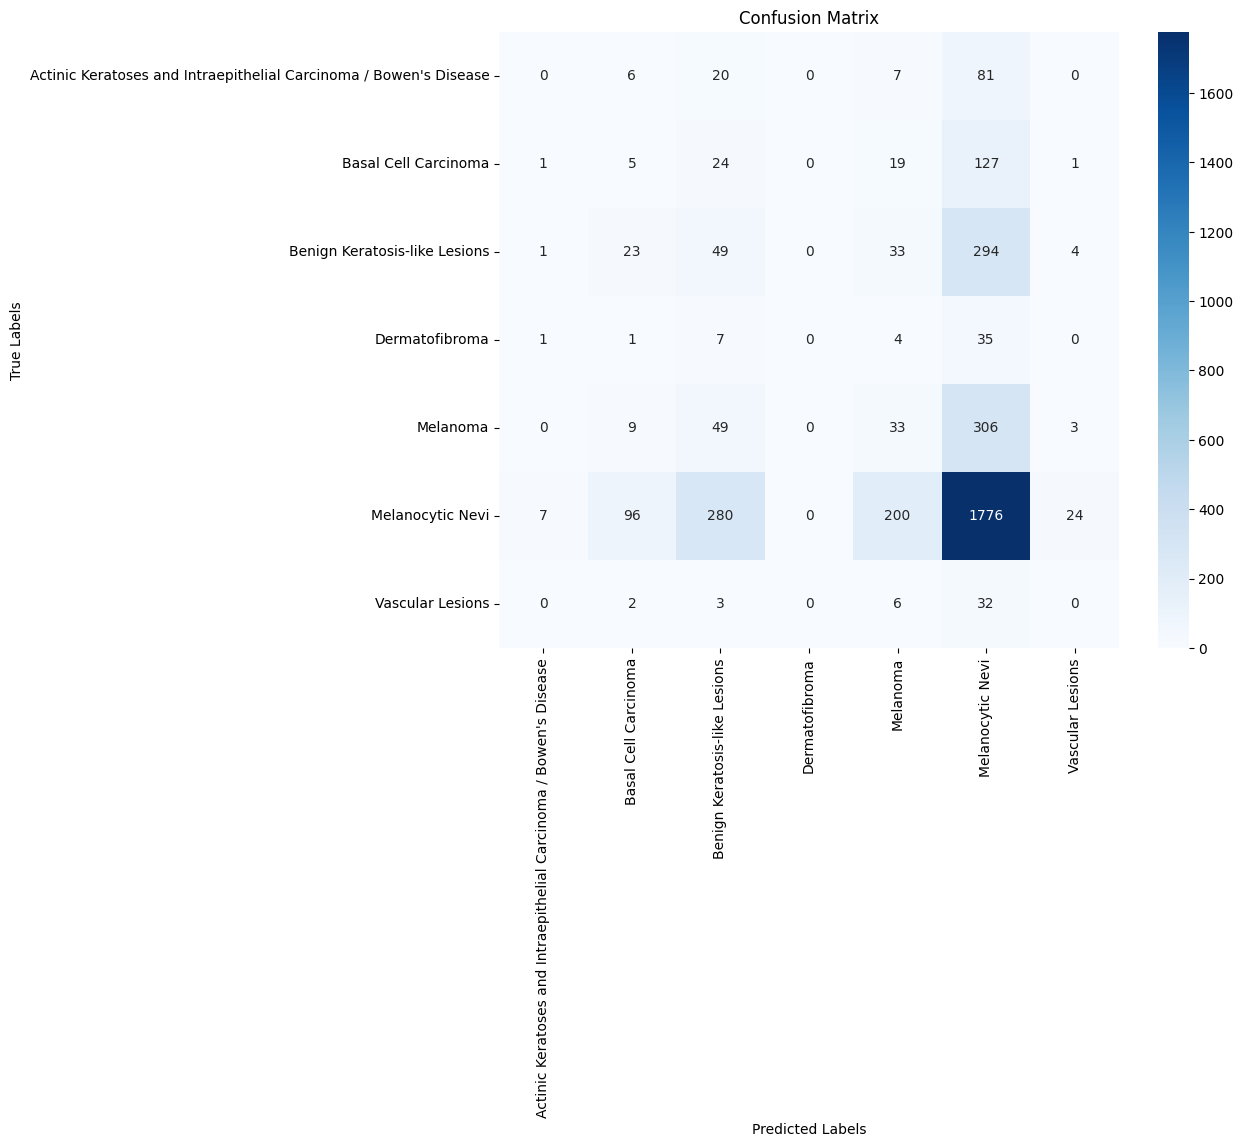

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the class names
class_names = [
    'Actinic Keratoses and Intraepithelial Carcinoma / Bowen\'s Disease', 
    'Basal Cell Carcinoma', 
    'Benign Keratosis-like Lesions', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic Nevi', 
    'Vascular Lesions'
]

# Assuming `test_generator` is your test data generator
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       114
         bcc       0.04      0.03      0.03       177
         bkl       0.11      0.12      0.12       404
          df       0.00      0.00      0.00        48
         mel       0.11      0.08      0.09       400
          nv       0.67      0.75      0.71      2383
        vasc       0.00      0.00      0.00        43

    accuracy                           0.52      3569
   macro avg       0.13      0.14      0.14      3569
weighted avg       0.47      0.52      0.50      3569



c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,